In [1]:
%matplotlib inline

import os
import json
import math
import sys
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import xgboost as xgb
import shap
import datetime
import warnings
warnings.filterwarnings("ignore")

notebook_path = !pwd
prj_path = os.path.abspath(os.path.join(notebook_path[0], '../', ''))
sys.path.append(prj_path)
print('Added: %s' % prj_path)

In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in 

Added: /Users/lsanchez/omath_mota_rulo


In [2]:
from data_scientia.features import train_data
from data_scientia.models.eval import eval_utils

In [3]:
data = train_data.get()

data.shape

(9839, 32)

In [4]:
target = 'is_next_peak_in_30_days'
forbiden = ['is_next_peak_in_7_days', 'is_next_peak_in_15_days', 'is_next_peak_in_20_days', 'is_next_peak_in_30_days']
train_boundary = '2020-09-01'
oos_size = .3

oot = data[data['fecha'] >= train_boundary]
train = data[data['fecha'] < train_boundary]

print(train.shape[0], oot.shape[0])

6534 3305


In [5]:
X_train = train.set_index(['fecha', 'nombre_hospital']).drop(forbiden, axis=1)
y_train = train.set_index(['fecha', 'nombre_hospital'])[target]

X_oot = oot.set_index(['fecha', 'nombre_hospital']).drop(forbiden, axis=1)
y_oot = oot.set_index(['fecha', 'nombre_hospital'])[target]


oos_idx = X_train.sample(int(oos_size * X_train.shape[0]), random_state=42).index
X_oos = X_train.loc[oos_idx]
y_oos = y_train.loc[oos_idx]

X_train.drop(oos_idx, inplace=True)
y_train.drop(oos_idx, inplace=True)

In [6]:
print(data.shape[0], X_train.shape[0], X_oos.shape[0], X_oot.shape[0])

9839 4574 1960 3305


In [7]:
model = xgb.XGBClassifier()

model.fit(
    X_train, 
    y_train,
    eval_set=[(X_train, y_train), (X_oos, y_oos)],
    eval_metric=['logloss', 'auc'],
    early_stopping_rounds=10,
    verbose=False)

y_train_score = model.predict_proba(X_train)
y_oos_score = model.predict_proba(X_oos)
y_oot_score = model.predict_proba(X_oot)

In [8]:
# Evaluate
print(eval_utils.classification_report(
    y_true=y_train, 
    y_score=y_train_score, 
    y_pred=(y_train_score[:, 1] > .5).astype(int)))

print(eval_utils.classification_report(
    y_true=y_oos, 
    y_score=y_oos_score, 
    y_pred=(y_oos_score[:, 1] > .5).astype(int)))

print(eval_utils.classification_report(
    y_true=y_oos, 
    y_score=y_oos_score, 
    y_pred=(y_oos_score[:, 1] > .5).astype(int)))

             precision    recall  f1-score  support    pred       AUC
0             0.999691  0.999074  0.999383   3240.0  3238.0  0.999998
1             0.997754  0.999250  0.998502   1334.0  1336.0  0.999998
avg / total   0.999126  0.999125  0.999126   4574.0  4574.0  0.999998
             precision    recall  f1-score  support    pred       AUC
0             0.981765  0.991163  0.986442   1358.0  1371.0  0.996621
1             0.979626  0.958472  0.968934    602.0   589.0  0.996621
avg / total   0.981108  0.981122  0.981064   1960.0  1960.0  0.996621
             precision    recall  f1-score  support    pred       AUC
0             0.981765  0.991163  0.986442   1358.0  1371.0  0.996621
1             0.979626  0.958472  0.968934    602.0   589.0  0.996621
avg / total   0.981108  0.981122  0.981064   1960.0  1960.0  0.996621


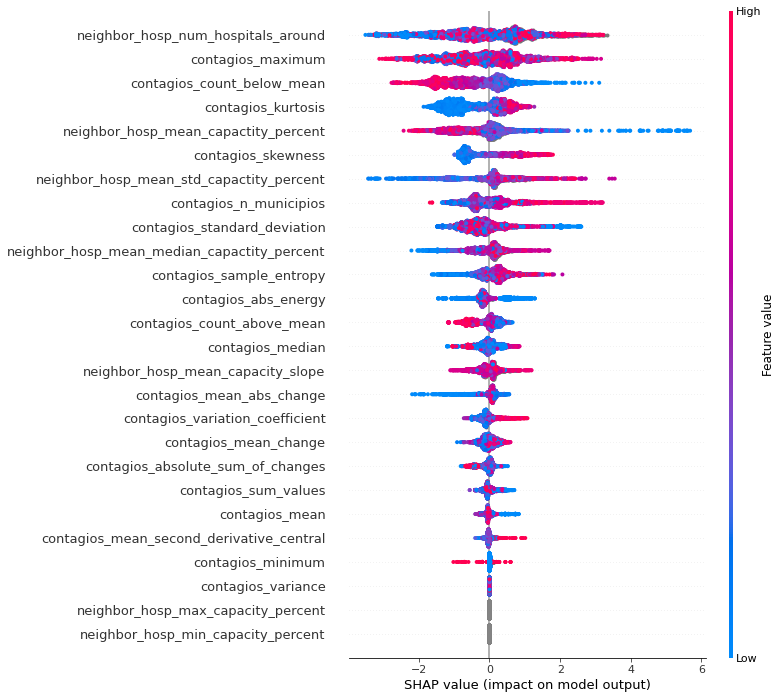

In [9]:
explainer = shap.TreeExplainer(model)
    
shaps_values = pd.DataFrame(
    explainer.shap_values(X_train),
    columns=X_train.columns)

shap.summary_plot(
    shaps_values.values, 
    X_train,
    max_display=1000)